## Optimal Route

How can you know the fastest way to get from point A to point B? Well you need to know the distance between points, of course. But what if there are multiple non-linear ways to get there? What then?

This is where experience comes in. Since we have taken certain paths to get from one point to another we know which path is the best. This is only discovered once we:
1) reach the end of the trip and
2) have tried multiple trip paths to know the best one.

Machines can learn the same way! We can provide an agent its environment, tell it where to start, where to end, and where to avoid. The agent will be rewarded only when it reaches its destination. Just like humans don't like waiting in traffic or taking all day to get somewhere, we can discount its final reward by diminishing its reward over time/different states. This will "motivate" the agent to pick routes that took as little time as possible. 

I'll set up a deterministic discrete 4 x 3 environment where there are states and actions that occur in turns. 

The agent will make an policy of moves it should take only once it reaches a terminal state, which in this case is 1 or -1. Once that maximum reward is found it will look back on which moves it took to get to that point. The values of each state will be the terminal state (either 1 or -1) + the value of the previous state + the value of the previous state, etc. Since the value of each state will be 0 the end result will just be 1, which is problematic if our agent is trying to maximize its reward. Why couldn't it just wander for a long period of time before transitioning to the +1 state and call THAT its optimal policy? This is where the discounting hyperparameter comes in.

If we can discount that reward of 1 with -0.1 each time the agent makes a transition between states, then it will want to make as few moves as possible to to maximize its reward. Once it does get to the end, it looks back at the moves it took to get there and calculates the value. So if it took 10 moves, the reward would be 0. Then it tries again. If the second round only took 6 moves, then the reward is 0.4 which is greater. The process repeats until the gain in reward no longer improves. Let's try it out. 

In [1]:
# Note: you may need to update your version of future
# sudo pip install -U future
from __future__ import print_function, division
from builtins import range
import numpy as np

class Grid: # Environment
    def __init__(self, width, height, start):
        self.width = width
        self.height = height
        self.i = start[0]
        self.j = start[1]
    
    # This function makes rewards and actions per state into class attributes but is added to the class once they are specified
    def set(self, rewards, actions):
        # rewards should be a dict of: (i, j): r (row, col): reward
        # actions should be a dict of: (i, j): A (row, col): list of possible actions
        self.rewards = rewards
        self.actions = actions
    
    # Takes a tuple of a state and assigns each x and y index to i and j
    def set_state(self, s):
        self.i = s[0]
        self.j = s[1]
    
    # Returns tuple of current state
    def current_state(self):
        return (self.i, self.j)
    
    # Checks if agent has reached a terminal state
    def is_terminal(self, s):
        return s not in self.actions
    
    # How the agent interacts with the environment
    def move(self, action):
        # Check if legal move first
        if action in self.actions[(self.i, self.j)]:
            if action == 'U':
                self.i -= 1
            elif action == 'D':
                self.i += 1
            elif action == 'R':
                self.j += 1
            elif action == 'L':
                self.j -= 1
        # Return a reward from that state if any. If none, return 0
        return self.rewards.get((self.i, self.j), 0)
    
    # Used to backtrack as the optimal policy is calculated
    def undo_move(self, action):
        # These are the opposite of what U/D/L/R should normally do
        if action == 'U':
            self.i += 1
        elif action == 'D':
            self.i -= 1
        elif action == 'R':
            self.j -= 1
        elif action == 'L':
            self.j += 1
        # Raise an exception if we arrive somewhere we shouldn't be
        assert(self.current_state() in self.all_states())
    
    # Returns true if game is over, else false
    def game_over(self):
        # true if we are in a state where no actions are possible
        return (self.i, self.j) not in self.actions
    
    # Simple way to get all states. ***Possibly buggy***
    def all_states(self):
        # Either a position that has possible next actions or a position that yields a reward
        return set(self.actions.keys()) | set(self.rewards.keys())

# Define a grid that describes the reward for arriving at each state and possible actions at each state
def standard_grid():
    g = Grid(3, 4, (2, 0))
    # 'rewards' disctionary has states as keys and consequnces as values
    rewards = {(0, 3): 1, (1, 3): -1}
    # 'actions' dictionary has states as keys and possible actions as values
    actions = {
    (0, 0): ('D', 'R'),
    (0, 1): ('L', 'R'),
    (0, 2): ('L', 'D', 'R'),
    (1, 0): ('U', 'D'),
    (1, 2): ('U', 'D', 'R'),
    (2, 0): ('U', 'R'),
    (2, 1): ('L', 'R'),
    (2, 2): ('L', 'R', 'U'),
    (2, 3): ('L', 'U'),
    }
    g.set(rewards, actions)
    return g

# Same as above but has a step cost / penalty for moving
def negative_grid(step_cost=-0.1):
    g = standard_grid()
    g.rewards.update({
    (0, 0): step_cost,
    (0, 1): step_cost,
    (0, 2): step_cost,
    (1, 0): step_cost,
    (1, 2): step_cost,
    (2, 0): step_cost,
    (2, 1): step_cost,
    (2, 2): step_cost,
    (2, 3): step_cost,
    })
    return g

In [2]:
# Test out the grid
g = Grid(width = 3, height = 4, start = (2,0))
grid = standard_grid()

# Check out all the states, the actions per state, and the possible rewards for the standard grid
print(grid.all_states(), '\n')
print(grid.actions, '\n')
print(grid.rewards, '\n')

# All is the same in the negative grid except the 'rewards' for all the neutral states are now -0.1
neg_grid = negative_grid()
print(neg_grid.rewards)

{(0, 1), (1, 2), (0, 0), (1, 3), (2, 1), (2, 0), (2, 3), (2, 2), (1, 0), (0, 2), (0, 3)} 

{(0, 1): ('L', 'R'), (1, 2): ('U', 'D', 'R'), (0, 0): ('D', 'R'), (2, 3): ('L', 'U'), (2, 0): ('U', 'R'), (1, 0): ('U', 'D'), (2, 2): ('L', 'R', 'U'), (0, 2): ('L', 'D', 'R'), (2, 1): ('L', 'R')} 

{(0, 3): 1, (1, 3): -1} 

{(0, 1): -0.1, (1, 2): -0.1, (1, 3): -1, (2, 1): -0.1, (0, 2): -0.1, (2, 0): -0.1, (0, 0): -0.1, (2, 3): -0.1, (2, 2): -0.1, (0, 3): 1, (1, 0): -0.1}


In [3]:
# Prints a representation of the map with the values given 
def print_values(V, g):
    for i in range(g.width):
        print("---------------------------")
        for j in range(g.height):
            v = V.get((i,j), 0)
            if v >= 0:
                print(" %.2f|" % v, end="")
            else:
                print("%.2f|" % v, end="") # -ve sign takes up an extra space
        print("")

# Prints out map with policy actions given each state
def print_policy(P, g):
    for i in range(g.width):
        print("---------------------------")
        for j in range(g.height):
            a = P.get((i,j), ' ')
            print("  %s  |" % a, end="")
        print("")

### Iterative Policy Evaluation

This method allows an agent to search all possible states and actions by first randomly allowing the agent to choose a policy, evaluate that policy and then update that policy until a certain criterion is met. In this case the criterion will be a threshold of value change. We take the maximum of the difference in value from one state to its next state. If the max value of all the states' changes in value is below 0.001 then we will consider the alrorithm to have converged.

NOTE:
There are 2 sources of randomness:

1) p(a|s) - deciding what action to take given the state

2) p(s',r|s,a) - the next state and reward given your action-state pair

We are only modeling p(a|s) = uniform. How would the code change if p(s',r|s,a) is not deterministic?

The neagtive grid being used gives you a reward of -0.1 for every non-terminal state. We want to see if this will encourage finding a shorter path to the goal.

In [11]:
# Here are some of the hyperparameters we can tweak to get different outputs
SMALL_ENOUGH = 1e-3
GAMMA = 0.9
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

if __name__ == '__main__':
    grid = negative_grid()

    print("Rewards:")
    print_values(grid.rewards, grid)

    # We'll randomly choose an action and update as we learn
    policy = {}
    for s in grid.actions.keys():
        policy[s] = np.random.choice(ALL_POSSIBLE_ACTIONS)

    print("Initial policy:")
    print_policy(policy, grid)

    # Initialize V(s)
    V = {}
    states = grid.all_states()
    for s in states:
        # V[s] = 0
        if s in grid.actions:
            V[s] = np.random.random()
        else:
            # Terminal state
            V[s] = 0

    # Repeat until convergence - will break out when policy does not change
    biggest_change_list = []
    while True:
        # Policy evaluation step
        while True:
            biggest_change = 0
            for s in states:
                old_v = V[s]
                # V(s) only has value if it's not a terminal state
                if s in policy:
                    a = policy[s]
                    grid.set_state(s)
                    r = grid.move(a)
                    V[s] = r + GAMMA * V[grid.current_state()]
                    biggest_change = max(biggest_change, np.abs(old_v - V[s]))
            biggest_change_list.append(biggest_change)
            if biggest_change < SMALL_ENOUGH:
                break
    
        # Policy improvement step
        is_policy_converged = True
        for s in states:
            if s in policy:
                old_a = policy[s]
                new_a = None
                best_value = float('-inf')
                # loop through all possible actions to find the best current action
                for a in ALL_POSSIBLE_ACTIONS:
                    grid.set_state(s)
                    r = grid.move(a)
                    v = r + GAMMA * V[grid.current_state()]
                    if v > best_value:
                        best_value = v
                        new_a = a
                policy[s] = new_a
                if new_a != old_a:
                    is_policy_converged = False
        if is_policy_converged:
            break

    print("Values:")
    print_values(V, grid)
    print("Policy:")
    print_policy(policy, grid)

Rewards:
---------------------------
-0.10|-0.10|-0.10| 1.00|
---------------------------
-0.10| 0.00|-0.10|-1.00|
---------------------------
-0.10|-0.10|-0.10|-0.10|
Initial policy:
---------------------------
  L  |  U  |  R  |     |
---------------------------
  U  |     |  D  |     |
---------------------------
  D  |  U  |  L  |  R  |
Values:
---------------------------
 0.62| 0.80| 1.00| 0.00|
---------------------------
 0.46| 0.00| 0.80| 0.00|
---------------------------
 0.31| 0.46| 0.62| 0.46|
Policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  R  |  U  |  L  |


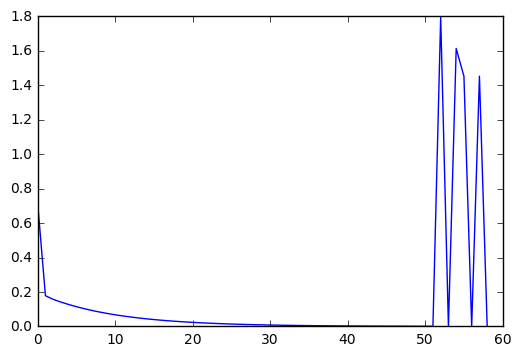

In [13]:
# Plot biggest change
import matplotlib.pyplot as plt 
plt.plot(biggest_change_list)
plt.show()

 ### Value Iteration
 
Iterating between policies to evaluate and then update them is not the only way to teach an agent to find its way from point A to point B. Instead we can iterate over the values themselves to find the optimal values and THEN update the policy at the end.

In [ ]:
if __name__ == '__main__':
    # this grid gives you a reward of -0.1 for every non-terminal state
    # we want to see if this will encourage finding a shorter path to the goal
    grid = negative_grid()

    # print rewards
    print("rewards:")
    print_values(grid.rewards, grid)

    # state -> action
    # we'll randomly choose an action and update as we learn
    policy = {}
    for s in grid.actions.keys():
        policy[s] = np.random.choice(ALL_POSSIBLE_ACTIONS)

    print("initial policy:")
    print_policy(policy, grid)

    # Initialize V(s)
    V = {}
    states = grid.all_states()
    for s in states:
        # V[s] = 0
        if s in grid.actions:
            V[s] = np.random.random()
        else:
            # Terminal state
            V[s] = 0

    # Repeat until convergence
    # V[s] = max[a]{ sum[s',r] { p(s',r|s,a)[r + GAMMA*V[s']] } }
    count = 0
    while True:
        count += 1
        biggest_change = 0
        for s in states:
            old_v = V[s]
            # V(s) only has value if it's not a terminal state
            if s in policy:
                new_v = float('-inf')
                for a in ALL_POSSIBLE_ACTIONS:
                    grid.set_state(s)
                    r = grid.move(a)
                    v = r + GAMMA * V[grid.current_state()]
                    if v > new_v:
                        new_v = v
                V[s] = new_v
                biggest_change = max(biggest_change, np.abs(old_v - V[s]))

        print(count,biggest_change)

        if biggest_change < SMALL_ENOUGH:
            break

    # find a policy that leads to optimal value function
    for s in policy.keys():
        best_a = None
        best_value = float('-inf')
        # loop through all possible actions to find the best current action
        for a in ALL_POSSIBLE_ACTIONS:
            grid.set_state(s)
            r = grid.move(a)
            v = r + GAMMA * V[grid.current_state()]
            if v > best_value:
                best_value = v
                best_a = a
        policy[s] = best_a

    # Our goal here is to verify that we get the same answer as with policy iteration
    print("values:")
    print_values(V, grid)
    print("policy:")
    print_policy(policy, grid)

### Monte Carlo Method

In [ ]:
# NOTE: this is only policy evaluation, not optimization

def play_game(grid, policy):
    # Returns a list of states and corresponding returns

    # Reset game to start at a random position
    # We need to do this, because given our current deterministic policy
    # We would never end up at certain states, but we still want to measure their value
    start_states = list(grid.actions.keys())
    start_idx = np.random.choice(len(start_states))
    grid.set_state(start_states[start_idx])
  
    s = grid.current_state()
    states_and_rewards = [(s, 0)] # list of tuples of (state, reward)
    while not grid.game_over():
        a = policy[s]
        r = grid.move(a)
        s = grid.current_state()
        states_and_rewards.append((s, r))
    # calculate the returns by working backwards from the terminal state
    G = 0
    states_and_returns = []
    first = True
    for s, r in reversed(states_and_rewards):
        # the value of the terminal state is 0 by definition
        # we should ignore the first state we encounter
        # and ignore the last G, which is meaningless since it doesn't correspond to any move
        if first:
            first = False
        else:
            states_and_returns.append((s, G))
        G = r + GAMMA*G
    states_and_returns.reverse() # we want it to be in order of state visited
    return states_and_returns


if __name__ == '__main__':
    # Use the standard grid again (0 for every step) so that we can compare to iterative policy evaluation
    grid = standard_grid()

    print("rewards:")
    print_values(grid.rewards, grid)

    # state -> action
    policy = {
    (2, 0): 'U',
    (1, 0): 'U',
    (0, 0): 'R',
    (0, 1): 'R',
    (0, 2): 'R',
    (1, 2): 'R',
    (2, 1): 'R',
    (2, 2): 'U',
    (2, 3): 'L',
    }

    # initialize V(s) and returns
    V = {}
    returns = {} # dictionary of state -> list of returns we've received
    states = grid.all_states()
    for s in states:
        if s in grid.actions:
          returns[s] = []
        else:
          # terminal state or state we can't otherwise get to
          V[s] = 0

    # repeat
    for t in range(100):
        # generate an episode using pi
        states_and_returns = play_game(grid, policy)
        seen_states = set()
        for s, G in states_and_returns:
            # check if we have already seen s
            # called "first-visit" MC policy evaluation
            if s not in seen_states:
                returns[s].append(G)
                V[s] = np.mean(returns[s])
                seen_states.add(s)

    print("values:")
    print_values(V, grid)
    print("policy:")
    print_policy(policy, grid)


### Summary


Sources:
    
https://deeplearningcourses.com/c/artificial-intelligence-reinforcement-learning-in-python
    
https://www.udemy.com/artificial-intelligence-reinforcement-learning-in-python